## Jax implementation of Jeffreys prior
for Ensemble Refinement and Force-Field Fitting

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../3_alphabetagamma/')

In [3]:
from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict

log det: some numerical technicalities to improve the calculations?

numerical stability? decompose the matrix... QR decomposition

https://github.com/b45ch1/algopy/issues/40



look at the Kish size (or the relative entropy) during the MC sampling

In [4]:
def compute_sqrt_det(variab, weights, if_cholesky = True):
    """
    Parameters:
    
        - variab is `data.mol[name_mol].g` for the observables and `(fun_forces, pars, f)` for the force-field corrections 
            where `ff_correction = data.mol[name_mol].ff_correction`, `f = data.mol[name_mol].f` and `fun_forces = jax.jacfwd(ff_correction, argnums=0)`
            the Jax function for the forces, compute it just once at the beginning of the MC sampling
        - weights
        - if_cholesky: if True, compute the determinant of the covariance matrix (which is real-value, symmetric and semi-positive definite)
            by means of the Cholesky decomposition (faster for big matrices)

    Return:

        - measure
        - cov
    """

    if type(variab) is tuple: values = variab[0](variab[1], variab[2])
    else: values = np.hstack([variab[s] for s in variab.keys()])
    
    av_forces = np.einsum('ti,t->i', values, weights)
    cov = np.einsum('ti,tj,t->ij', values, values, weights) - np.outer(av_forces, av_forces)

    if not if_cholesky:
        measure = np.sqrt(np.linalg.det(cov))
    else:  # alternatively, exploit the Cholesky decomposition
        triang = np.linalg.cholesky(cov)
        measure = np.prod(np.diag(triang))

    return measure, cov

### 1. load data

In [5]:
infos = {'global': {
    'path_directory': '../../3_alphabetagamma/DATA',
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],#, 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1000

In [6]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [7]:
infos['global']['forward_model'] = forward_model_fun

In [8]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [9]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA


done


### 2. normalize observables and find the optimal solution at given $\alpha$

In [11]:
name_mol = 'AAAA'

normalization: just once, at the beginning of Metropolis sampling

in order to simplify a pre-factor in the Jeffreys prior

In [12]:
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

data.mol[name_mol].g = out[0]
data.mol[name_mol].gexp = out[1]
data.mol[name_mol].normg_mean = out[2]
data.mol[name_mol].normg_std = out[3]

In [13]:
result = minimizer(data, alpha=1)  # this will be used in the next section, n.3

#### compute determinant of the covariance matrix

In [15]:
weights = data.mol[name_mol].weights

In [88]:
measures = {}
covs = {}

In [89]:
measures['obs 0'], covs['obs 0'] = compute_sqrt_det(data.mol[name_mol].g, weights)


[[ 1.         -0.29149885  0.01735947 -0.04533156 -0.08684404  0.00701764
   0.01352898 -0.00567202]
 [-0.29149885  1.         -0.05133508  0.00361689  0.01100069  0.01325561
   0.01352259 -0.0422562 ]
 [ 0.01735947 -0.05133508  1.         -0.40119278 -0.05425761  0.01614637
   0.07072628  0.01768687]
 [-0.04533156  0.00361689 -0.40119278  1.         -0.00328277  0.04931041
  -0.04845965 -0.0476785 ]
 [-0.08684404  0.01100069 -0.05425761 -0.00328277  1.         -0.30123642
   0.0097381   0.00540063]
 [ 0.00701764  0.01325561  0.01614637  0.04931041 -0.30123642  1.
  -0.01763084  0.00309083]
 [ 0.01352898  0.01352259  0.07072628 -0.04845965  0.0097381  -0.01763084
   1.         -0.2648906 ]
 [-0.00567202 -0.0422562   0.01768687 -0.0476785   0.00540063  0.00309083
  -0.2648906   1.        ]]
0.7923829944167935


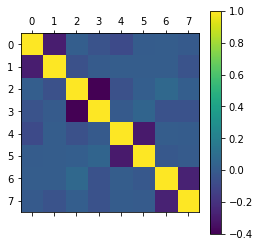

In [90]:
print(covs['obs 0'])
print(measures['obs 0'])

plt.matshow(covs['obs 0'])
plt.colorbar()

In [91]:
ff_correction = data.mol[name_mol].ff_correction

f = data.mol[name_mol].f
fun_forces = jax.jacfwd(ff_correction, argnums=0)
pars = np.ones(2)

measures['ff 0'], covs['ff 0'] = compute_sqrt_det((fun_forces, pars, f), weights)

[[ 2.52710053 -0.0132658 ]
 [-0.0132658   0.46250783]]
1.0810309008931311


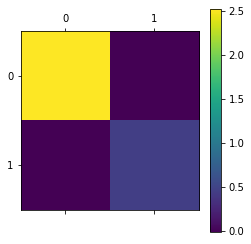

In [92]:
print(covs['ff 0'])
print(measures['ff 0'])

plt.matshow(covs['ff 0'])
plt.colorbar()

In [94]:
vars(result)

result.min_lambdas['AAAA']['backbone1_gamma_3J']

DeviceArray([-0.31842614, -0.01857903,  0.05312712,  0.43365863,
             -0.01175906,  0.02321191,  0.17189324,  0.01144479],            dtype=float64)

In [95]:
weights_new = result.weights_new[name_mol]

In [96]:
measures['obs opt'], covs['obs opt'] = compute_sqrt_det(data.mol[name_mol].g, weights_new)

In [97]:
# notice this is the force-field correction with the reweighted ensemble from Ensemble Refinement
# pars are arbitrarily chosen (they should be zero)
measures['ff opt'], covs['ff opt'] = compute_sqrt_det((fun_forces, pars, f), weights_new)

0.7923829944167935 0.43084602583072845


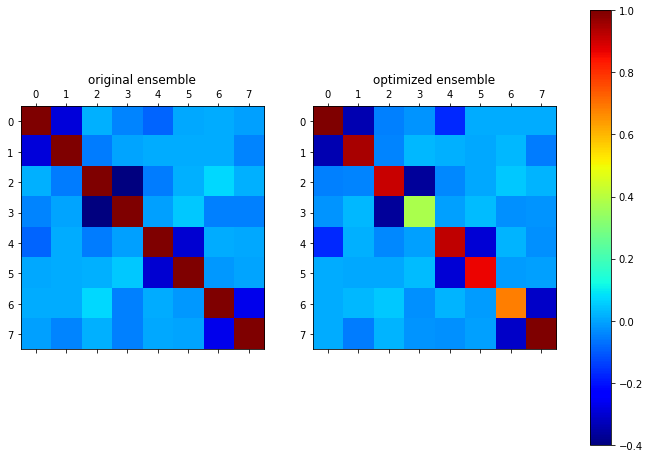

In [98]:
# print(covs['obs opt'])
print(measures['obs 0'], measures['obs opt'])

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].matshow(covs['obs 0'], cmap='jet')
axs[0].set_title('original ensemble')

minim = np.min(covs['obs 0'])
maxim = np.max(covs['obs 0'])

im = axs[1].matshow(covs['obs opt'], cmap='jet', vmin=minim, vmax=maxim)
axs[1].set_title('optimized ensemble')

plt.colorbar(im, ax=axs.ravel().tolist())

### 3. sample the posterior at this given value of the hyperparameters
(only $\alpha$ is finite, $\alpha=1$)

In [14]:
from MDRefine.MDRefine import loss_function

In [15]:
lambdas = result.min_lambdas
result.loss

DeviceArray(4.93328183, dtype=float64)

In [16]:
flatten_lambda = []
for name_mol in data.properties.system_names:
    flatten_lambda = flatten_lambda + list(
        np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

flatten_lambda = np.array(flatten_lambda)

#### compute and plot

In [15]:
loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda)

DeviceArray(0.23305309, dtype=float64)

In [17]:
out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda, if_save=True)

vars(out)

out.weights_new['AAAA']

DeviceArray([0.00094964, 0.00465282, 0.00138673, ..., 0.00357721,
             0.00054432, 0.00068441], dtype=float64)

In [20]:
from MDRefine.MDRefine import unwrap_2dict

In [22]:
unwrap_2dict(out.av_g)[0]

[0.4953040371504909,
 -0.09211051239620076,
 0.1027091589719978,
 -0.24223835854776427,
 -0.01949509826121472,
 -0.03654642834980219,
 -0.12391739241835345,
 0.04926049889864188]

In [17]:
result.weights_new['AAAA']

DeviceArray([0.00094964, 0.00465282, 0.00138673, ..., 0.00357721,
             0.00054432, 0.00068441], dtype=float64)

ok, it's correct

In [25]:
new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)

In [99]:
out.loss

DeviceArray(-0.09879385, dtype=float64)

In [100]:
out.loss_explicit

DeviceArray(1.66093957, dtype=float64)

In [26]:
measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])

np.log(measure)

-0.8544059123353879

In [111]:
out.av_g['AAAA']

{'backbone1_gamma_3J': DeviceArray([ 0.50916402, -0.09252045,  0.09863359, -0.24216431,
              -0.01452123, -0.04849545, -0.11934694,  0.04335737],            dtype=float64)}

In [113]:
values = []
avgs = []

for i in range(500):
    
    new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)
    measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])

    values.append([out.loss_explicit, np.log(measure)])
    avgs.append(out.av_g['AAAA']['backbone1_gamma_3J'])

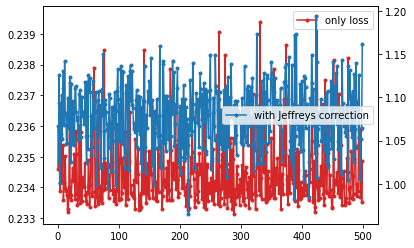

In [114]:
values = np.array(values)

fig, ax1 = plt.subplots()

ax1.plot(values[:, 0], '.-', color='tab:red', label='only loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(values[:, 0] - values[:, 1], '.-', color='tab:blue', label='with Jeffreys correction')

ax2.legend(loc='right')


In [115]:
avgs = np.array(avgs)

0.4973220491712732 0.49717869507805346
-0.09249466000793734 -0.09257890704388447
0.10234265508619518 0.10227025229620289
-0.24226997017437946 -0.2422695621302754
-0.01911582306201865 -0.01916527454955963
-0.03703483412730105 -0.03716348478325686
-0.12402143637356737 -0.12404685219074535
0.049523285184505196 0.04938880937941742


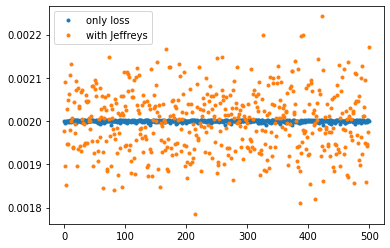

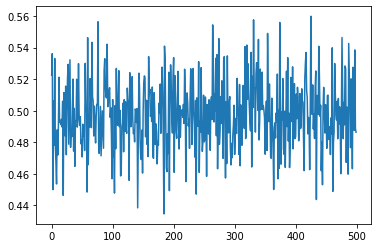

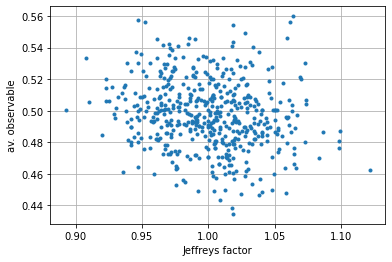

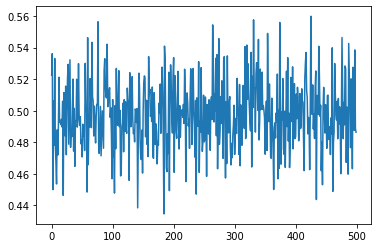

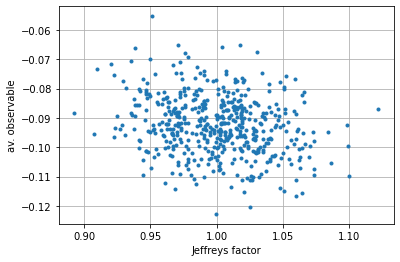

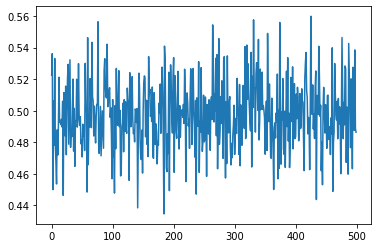

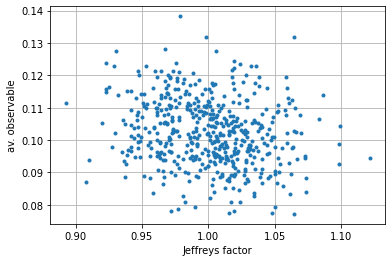

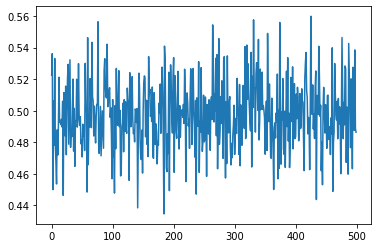

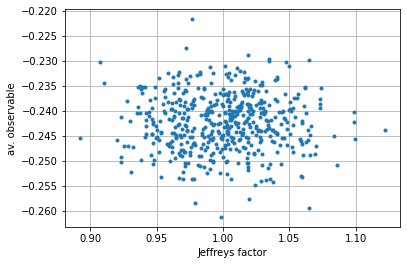

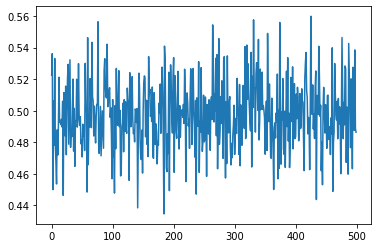

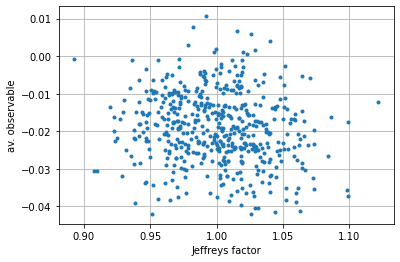

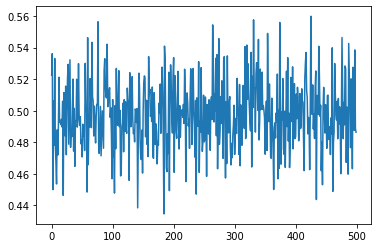

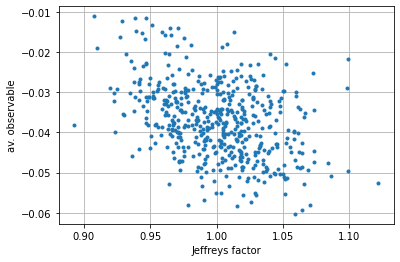

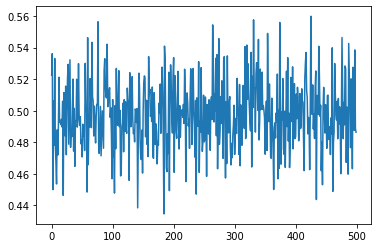

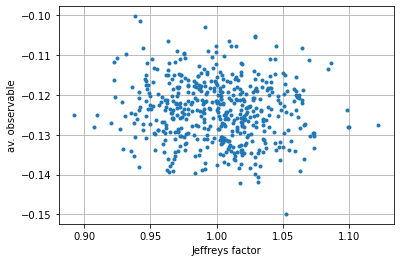

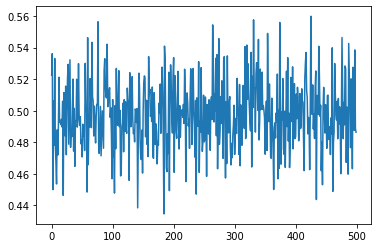

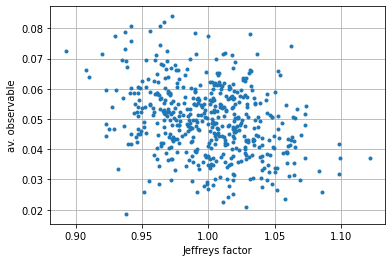

In [117]:
bayes_weight = np.exp(-values[:, 0])
bayes_weight = bayes_weight/np.sum(bayes_weight)

bayes_weight2 = np.exp(-values[:, 1])
bayes_weight2 = bayes_weight2/np.sum(bayes_weight2)

plt.plot(bayes_weight, '.', label='only loss')
plt.plot(bayes_weight2, '.', label='with Jeffreys')
plt.legend()

for i_obs in range(avgs.shape[1]):

    bayes_av = np.sum(bayes_weight*avgs[:, i_obs])
    bayes_av2 = np.sum(bayes_weight2*avgs[:, i_obs])

    plt.figure()
    plt.plot(avgs[:, 0])

    print(bayes_av, bayes_av2)

    plt.figure()
    plt.plot(bayes_weight2/bayes_weight, avgs[:, i_obs], '.')
    plt.xlabel('Jeffreys factor')
    plt.ylabel('av. observable')
    plt.grid()

#### Metropolis sampling

In [16]:
from basic_functions import run_Metropolis

In [17]:
x0 = flatten_lambda

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.01])}

def energy_fun(lambdas, if_Jeffreys):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=lambdas, if_save=True)
    
    energy = out.loss_explicit

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol], if_cholesky=True)
        energy -= np.log(measure)
    
    return energy, av_g

In [34]:
energy_function = {'fun': energy_fun, 'args': ([True])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


In [36]:
energy_function = {'fun': energy_fun, 'args': ([True])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


In [ ]:
np.linalg.decom

In [22]:
sampling_J[2]

0.99

In [22]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=100)

0


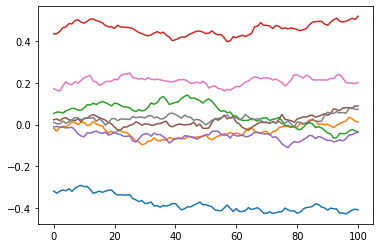

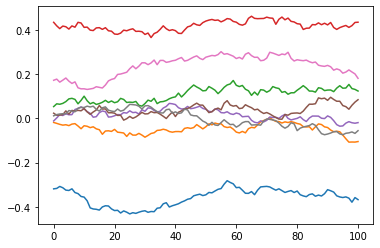

In [23]:
for i in range(8):

    plt.plot(sampling_J[0][:, i], '-', label='with Jeffreys prior')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(8):
    plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

In [26]:
sampling_J[1]

array([1.0750585 , 1.0514449 , 1.06004482, 1.15150627, 1.17333082,
       1.19004651, 1.21253009, 1.24385605, 1.21146228, 1.18885473,
       1.23552681, 1.27980871, 1.30111075, 1.30348699, 1.24349188,
       1.21474477, 1.18795944, 1.13961049, 1.09824831, 1.11880218,
       1.11183752, 1.07742503, 1.09867479, 1.09733817, 1.09733817,
       1.09735797, 1.02353604, 0.99331286, 0.999394  , 0.99144065,
       0.99744498, 1.0495177 , 1.03916808, 1.06923729, 1.07325802,
       1.07791954, 1.08299801, 1.05439392, 0.993437  , 0.9845514 ,
       1.01005119, 1.04205133, 1.0542575 , 1.09238811, 1.09292676,
       1.06378659, 1.05336598, 1.02713016, 1.03324191, 0.99933733,
       0.99589527, 0.97128111, 1.05613094, 1.09317846, 1.06116733,
       1.04395417, 1.05358672, 1.00147653, 0.9901857 , 1.04805042,
       0.98883759, 0.95611408, 0.94485081, 0.98197593, 0.97559001,
       1.03447787, 1.07370644, 1.06945865, 1.08814323, 1.1016203 ,
       1.1016203 , 1.03479671, 1.05123636, 1.05630843, 1.08348

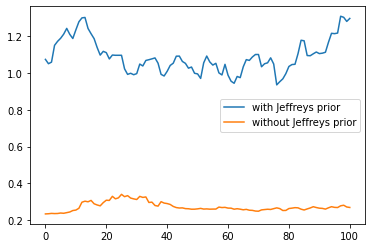

In [27]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()
# plt.text(2000, 0, s='av. acceptance: with J.' + str(sampling_J[2]) + '; without J.' + str(sampling_noJ[2]))

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


#### try in lower dimensionality

In [28]:
vars(data.mol['AAAA'])

{'temperature': 1.0,
 'gexp': {'backbone1_gamma_3J': DeviceArray([[ 0.6510965 ,  0.70121354],
               [-0.08500965,  0.60379414],
               [ 0.03650918,  1.11244602],
               [-0.52931627,  0.81365266],
               [-0.00961196,  0.92763887],
               [-0.0484394 ,  0.71896851],
               [-0.18516992,  0.59697546],
               [ 0.03907911,  0.93452099]], dtype=float64)},
 'names': {'backbone1_gamma_3J': array([['0-1H5H4'],
         ['0-2H5H4'],
         ['1-1H5H4'],
         ['1-2H5H4'],
         ['2-1H5H4'],
         ['2-2H5H4'],
         ['3-1H5H4'],
         ['3-2H5H4']], dtype='<U7')},
 'ref': {'backbone1_gamma_3J': '='},
 'forward_model': <function MDRefine.MDRefine.data_loading.data_class.__init__.<locals>.my_forward_model(a, b, c=None)>,
 'forward_qs': {'backbone1_gamma': memmap([[-0.7815259 ,  1.3352288 , -1.1212994 , ...,  1.185426  ,
           -0.83515507,  1.1691177 ],
          [-3.0438728 , -0.9504671 , -0.9597394 , ...,  0.96110785,

In [14]:
s = 'backbone1_gamma_3J'

assert list(data.mol.keys()) == ['AAAA']
assert list(data.mol['AAAA'].g.keys()) == [s]

data.mol['AAAA'].gexp[s] = data.mol['AAAA'].gexp[s][:2, :]
data.mol['AAAA'].g[s] = data.mol['AAAA'].g[s][:, :2]
# data.mol['AAAA'].normg_mean[s] = data.mol['AAAA'].normg_mean[s][:2]
# data.mol['AAAA'].normg_std[s] = data.mol['AAAA'].normg_std[s][:2]
data.mol['AAAA'].n_experiments[s] = 2

In [15]:
out = minimizer(data, alpha=1)

vars(out)

{'loss': DeviceArray(0.11523865, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}},
 'minis': {'AAAA':       fun: -0.1152386542106145
   hess_inv: array([[0.38770197, 0.05015591],
         [0.05015591, 0.91372151]])
        jac: array([-0.00018545,  0.00024437])
    message: 'Optimization terminated successfully.'
       nfev: 6
        nit: 4
       njev: 6
     status: 0
    success: True
          x: array([-0.32268477, -0.01043889])},
 'time': 0.5969316959381104,
 'D_KL_alpha': {'AAAA': DeviceArray(0.08967682, dtype=float64)},
 'abs_difference': {'AAAA': DeviceArray(1.16872218e-07, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': DeviceArray([ 0.49261772, -0.08905969], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': DeviceArray(0.05112391, dtype=float64)}},
 'logZ_new': {'AAAA': DeviceArray(0.06835373, dtype=float64)},
 'weights_new': {'AAAA': DeviceArray([0.0010913 , 0.00356539, 0.00092513, 

In [16]:
x_min = out.min_lambdas

x_min

{'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}}

In [17]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

In [18]:
x_min = flat_lambda(x_min)

x_min

array([-0.32268477, -0.01043889])

In [19]:
n = 30
delta = 1

x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [23]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


In [258]:
vmax

13.119052571589295

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


0.1411825716663658 23.944606399470103


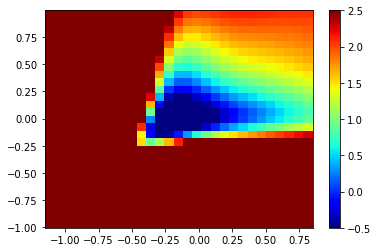

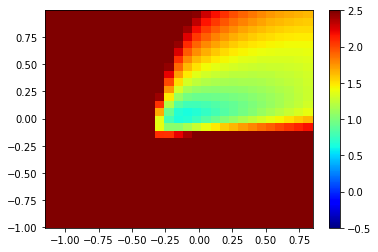

In [95]:
# matplotlib.rcParams['pcolor.shading']

# vmin = np.min(grid_vals_J)
# # vmax = np.max(grid_vals_J)
# vmax = vmin + 8

vmin = -0.5
vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


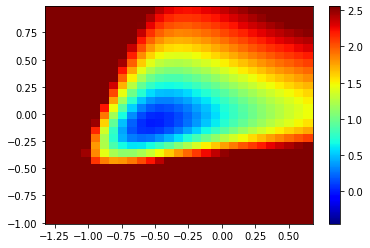

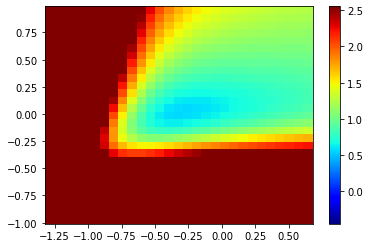

In [42]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
# vmax = np.max(grid_vals_J)
vmax = vmin + 3

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

In [90]:
x0 = x_min

In [24]:
energy_function = {'fun': energy_fun, 'args': ([True])}

proposal_full = {'fun': proposal, 'args': ([2])}

sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

NameError: name 'energy_fun' is not defined

In [92]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


Text(0.5, 1.0, 'lambdas without Jeffreys prior')

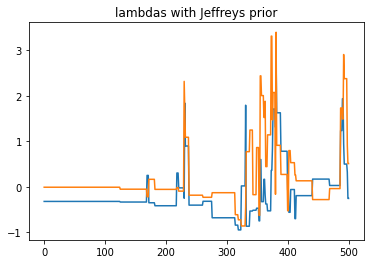

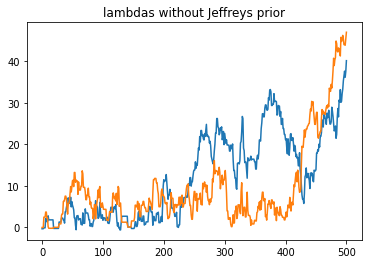

In [66]:
for i in range(2):

    plt.plot(sampling_J[0][:, i], '-')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.title('lambdas with Jeffreys prior')

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(2):
    plt.plot(sampling_noJ[0][:, i], '-')
    # plt.legend()

plt.title('lambdas without Jeffreys prior')

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

av. acceptance: with J.0.094; without J.0.74


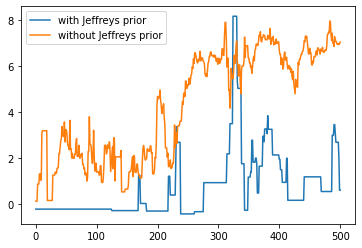

In [67]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()

s = 'av. acceptance: with J.' + str(sampling_J[-1]) + '; without J.' + str(sampling_noJ[-1])
# plt.text(2000, 0, s=s)

print(s)

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


### 4. sampling force-field corrections

(only $\beta$ is finite, $\beta=1$)

In [17]:
from MDRefine.MDRefine import loss_function, unwrap_2dict
from basic_functions import run_Metropolis

In [18]:
result = minimizer(data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1)

New evaluation:
loss:  11.521512314581095
gradient:  [-0.7802033   1.21695309] 

New evaluation:
loss:  10.667717746661411
gradient:  [0.3009919 0.8103643] 

New evaluation:
loss:  9.410267706810714
gradient:  [0.52665325 0.55311348] 

New evaluation:
loss:  20.26823840136523
gradient:  [-30.60903252  -1.6283888 ] 

New evaluation:
loss:  9.128081145718845
gradient:  [0.09899359 0.4657037 ] 

New evaluation:
loss:  8.696578385743122
gradient:  [-0.50011307  0.23770237] 

New evaluation:
loss:  8.519221822554165
gradient:  [0.99300136 0.01582728] 

New evaluation:
loss:  8.450800751738443
gradient:  [-0.11379899 -0.01165558] 

New evaluation:
loss:  8.450250249462151
gradient:  [0.04727243 0.00379192] 

New evaluation:
loss:  8.450145021704593
gradient:  [0.00130913 0.00012077] 

New evaluation:
loss:  8.450144937250075
gradient:  [-1.52400954e-05 -1.80080382e-06] 



In [19]:
pars = result.pars

pars

array([ 0.41205508, -6.07639728])

In [20]:
x0 = pars

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([2.0])}

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)


def energy_fun(pars, if_Jeffreys):
    
    out = loss_function(pars, data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    energy = out.loss  # which is loss_explicit if alpha is infinite

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = compute_sqrt_det((fun_forces, pars, data.mol[name_mol].f), data.mol[name_mol].weights)
        energy -= np.log(measure)
    
    return energy, av_g

In [21]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=100)

0


In [22]:
traj = sampling_J[0]
ene = sampling_J[1]
quantities = sampling_J[2]
av_alpha = sampling_J[3]

0.62


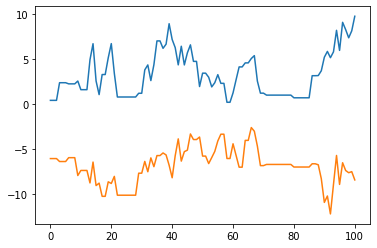

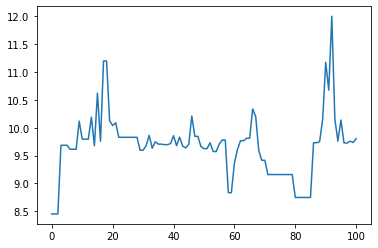

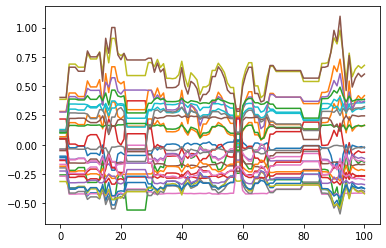

In [23]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.958


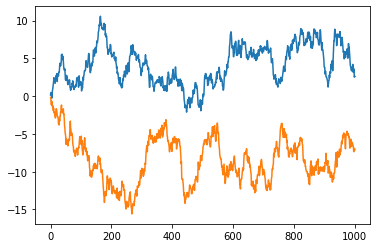

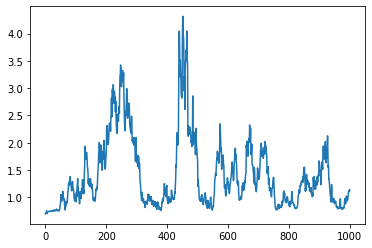

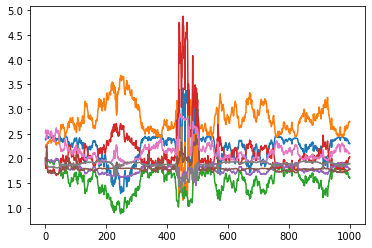

In [47]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.862


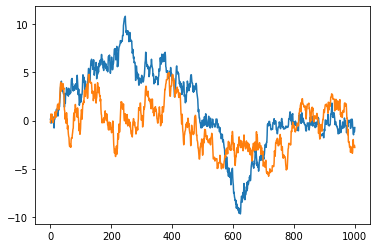

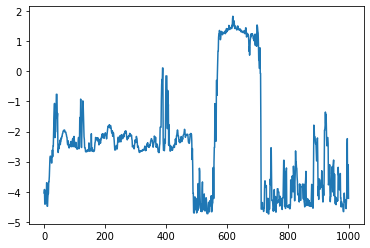

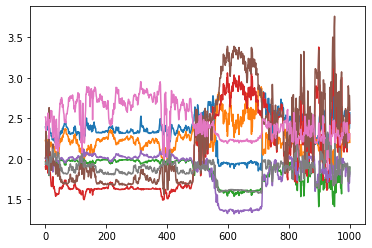

In [44]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.792


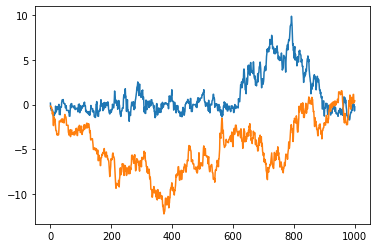

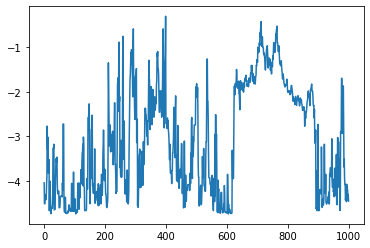

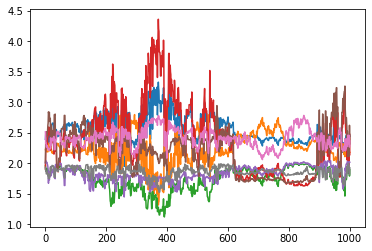

In [41]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

since we have just 2 coefficients, we can plot the posterior

In [71]:
n = 30
delta = 10

x = np.linspace(x0[0] - delta, x0[1] + delta, n)
y = np.linspace(x0[1] - delta, x0[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [82]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)
grid_vals_avg = np.zeros((sh[0], sh[1], 8))

name_mol = 'AAAA'

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.array([x[i], y[j]]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        grid_vals_noJ[i, j] = out.loss
        grid_vals_avg[i, j, :] = np.array(unwrap_2dict(out.av_g)[0])

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


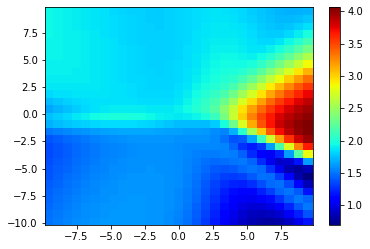

In [90]:
plt.pcolormesh(x, y, grid_vals_avg[:, :, 7], cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


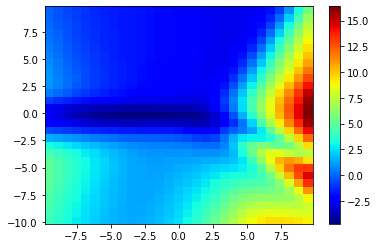

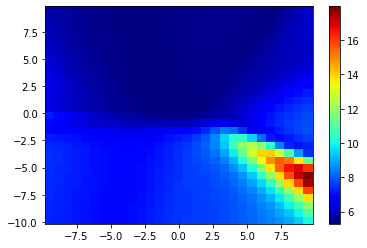

In [73]:
# plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


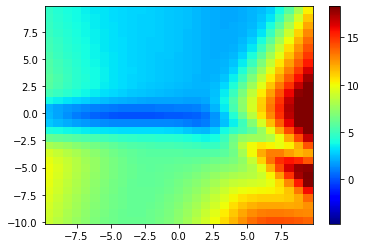

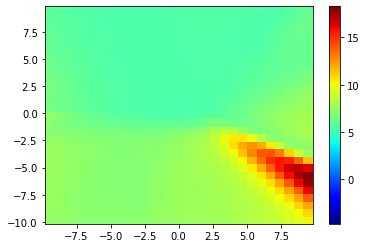

In [74]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
vmax = np.max(grid_vals_J)
# vmax = vmin + 8

# vmin = -0.5
# vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

# print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))